In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
palette = 'colorblind'
import seaborn as sns; sns.set_palette(palette); sns.set_color_codes(palette)
import statsmodels.formula.api as smf 

#### Code 5.1

In [2]:
# load data
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# standardize predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

In [3]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_1 = pm.sample(1000)

100%|██████████| 1000/1000 [00:02<00:00, 356.97it/s]


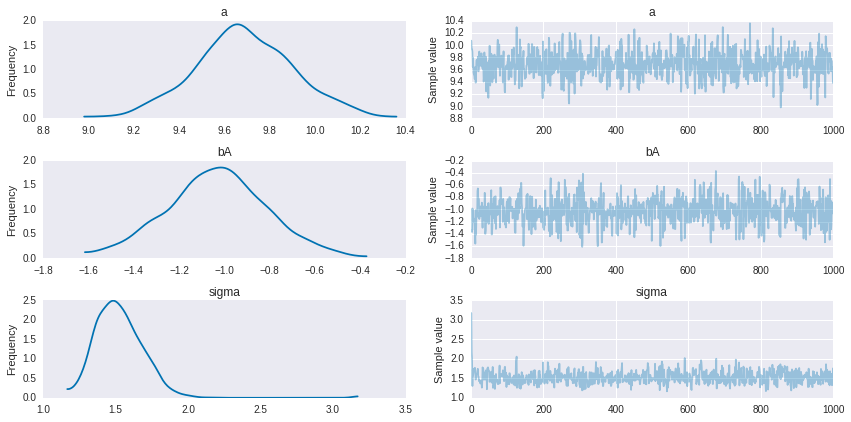

In [4]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_1, varnames);

#### Code 5.2

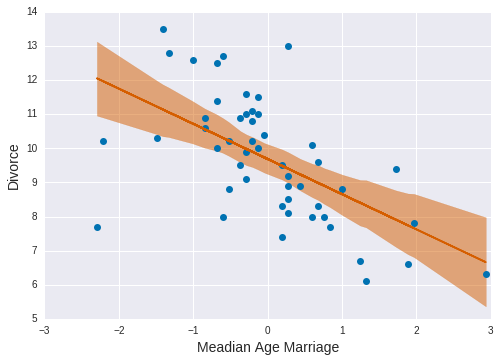

In [5]:
mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.MedianAgeMarriage_s, d.Divorce, 'bo')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'r')

idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)

plt.xlabel('Meadian Age Marriage', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

##### Code 5.3

In [6]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [7]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_2 = pm.sample(1000)

100%|██████████| 1000/1000 [00:02<00:00, 373.74it/s]


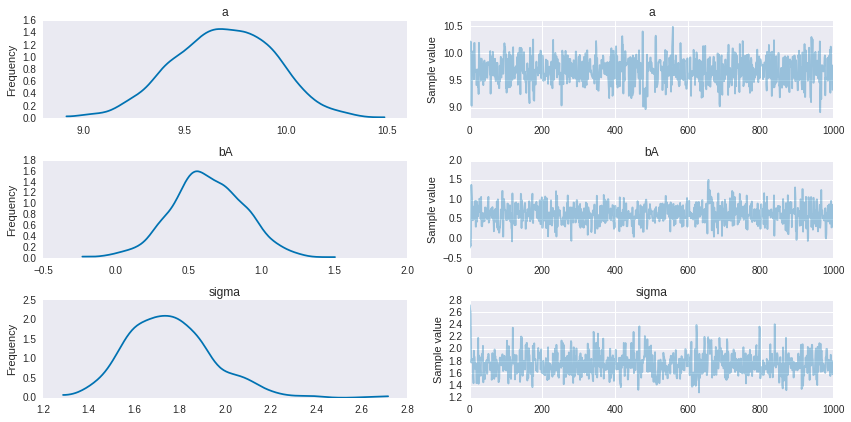

In [8]:
pm.traceplot(trace_5_2, varnames);

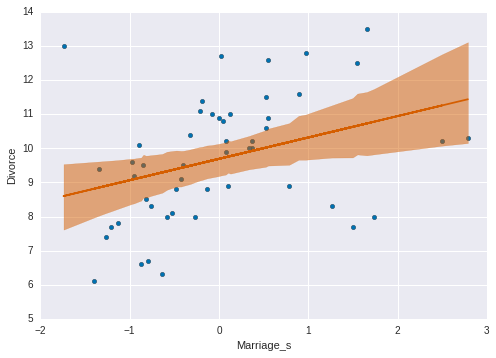

In [9]:
mu_mean = trace_5_2['mu']
mu_hpd = pm.hpd(mu_mean)

d.plot('Marriage_s', 'Divorce', kind='scatter', xlim = (-2, 3))
plt.plot(d.Marriage_s, mu_mean.mean(0), 'r')

idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5);

#### Code 5.4

In [10]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=10, sd=10)
    bA = pm.Normal('bA', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_3 = pm.sample(1000)

100%|██████████| 1000/1000 [00:04<00:00, 240.19it/s]


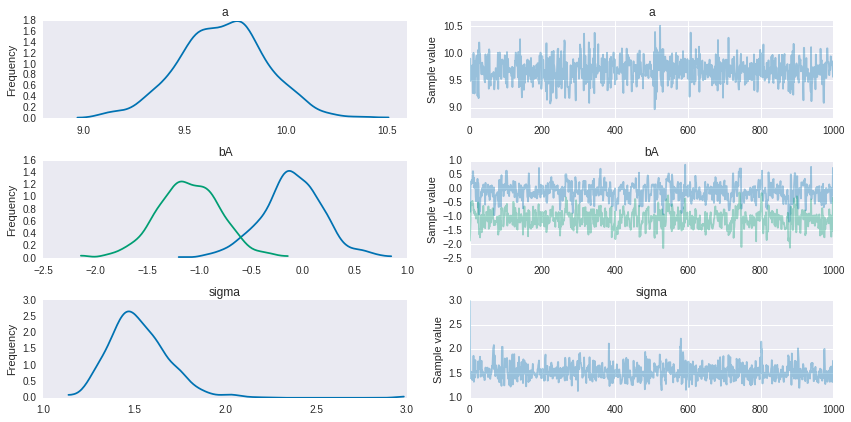

In [11]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_3, varnames);

In [12]:
pm.df_summary(trace_5_3, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,9.688563,0.219410,0.007653,9.266682,10.092510
bA__0,-0.105994,0.301427,0.015948,-0.785531,0.452898
bA__1,-1.102688,0.307471,0.015549,-1.693213,-0.485169
sigma,1.530726,0.171259,0.006177,1.254429,1.847078


#### Code 5.5

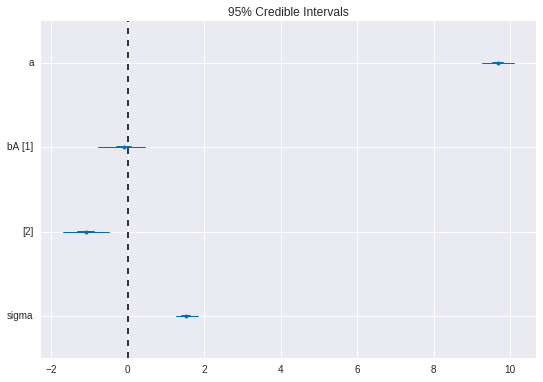

In [13]:
pm.forestplot(trace_5_3, varnames);

#### Code 5.6

In [14]:
with pm.Model() as model_5_4:
    a = pm.Normal('a', mu=10, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000)

100%|██████████| 1000/1000 [00:03<00:00, 302.49it/s]


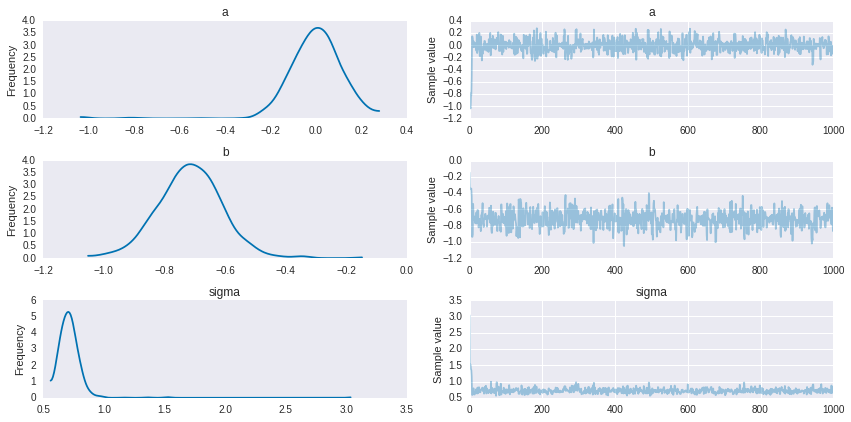

In [15]:
varnames = ['a', 'b', 'sigma']
pm.traceplot(trace_5_4, varnames);

#### Code 5.7

In [16]:
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.Marriage_s - mu_pred

#### Code 5.8

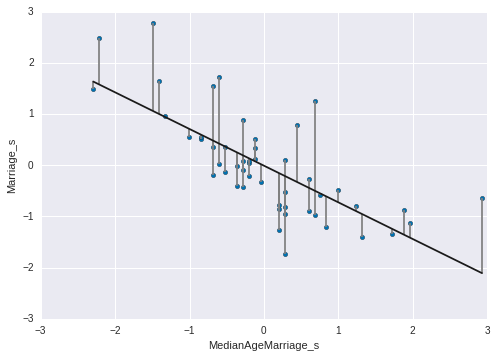

In [17]:
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred[idx], 'k')
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, colors='grey');

#### Code 5.9

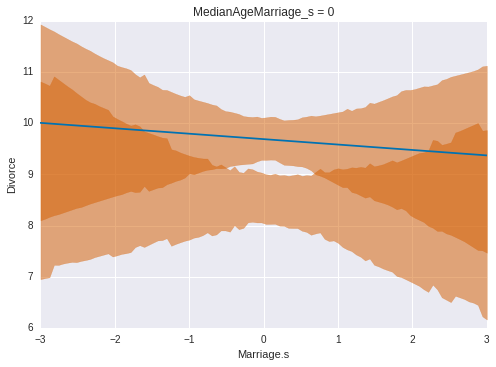

In [18]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,0] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.plot(R_avg, mu_pred.mean(1), 'b');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='r', alpha=0.5)

plt.xlabel('Marriage.s')
plt.ylabel('Divorce')
plt.title('MedianAgeMarriage_s = 0');

#### Code 5.10

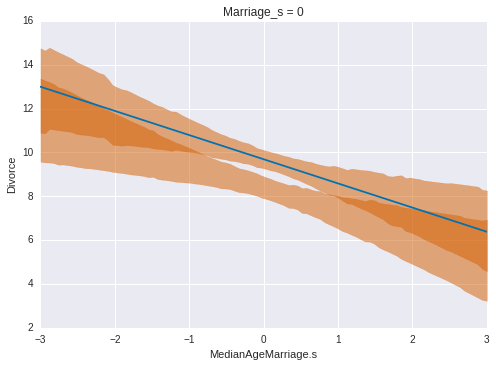

In [19]:
R_avg = np.linspace(-3, 3, 100)

mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,1] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)


plt.plot(R_avg, mu_pred.mean(1), 'b');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='r', alpha=0.5)

plt.xlabel('MedianAgeMarriage.s')
plt.ylabel('Divorce')
plt.title('Marriage_s = 0');

#### Code 5.11

In [20]:
mu_pred = trace_5_3['mu']
mu_hpd = pm.hpd(mu_pred)

divorce_pred = pm.sample_ppc(trace_5_3, samples=1000, model=model_5_3)['Divorce']
divorce_hpd = pm.hpd(divorce_pred)

100%|██████████| 1000/1000 [00:24<00:00, 40.51it/s]


#### Code 5.12

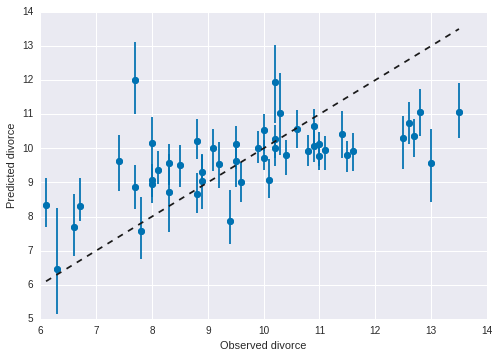

In [21]:
mu_hpd = pm.hpd(mu_pred, alpha=0.05)
plt.errorbar(d.Divorce, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0)-mu_hpd.T) , fmt='bo')
plt.plot(d.Divorce, divorce_pred.mean(0), 'bo')

plt.xlabel('Observed divorce')
plt.ylabel('Predicted divorce')

min_x, max_x = d.Divorce.min(), d.Divorce.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

#### Code 5.14

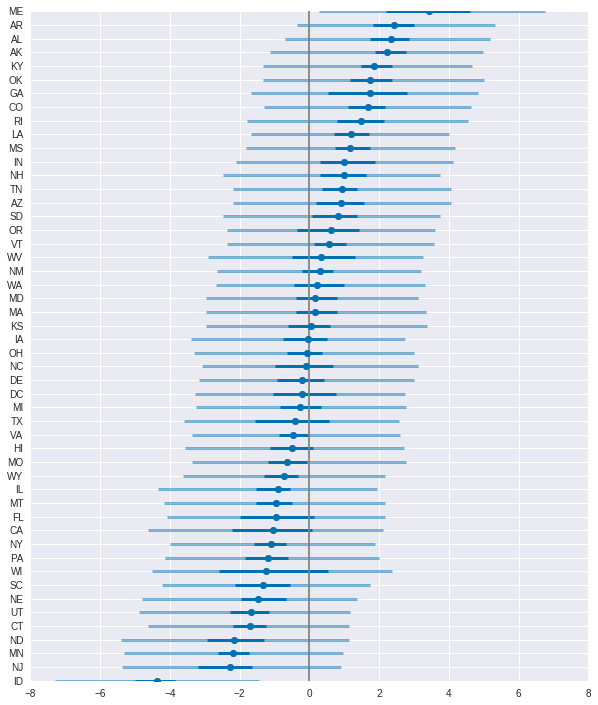

In [22]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-mu_hpd.T),
             fmt='bo',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-divorce_hpd.T),
             fmt='bo', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey');

#### Code 5.15

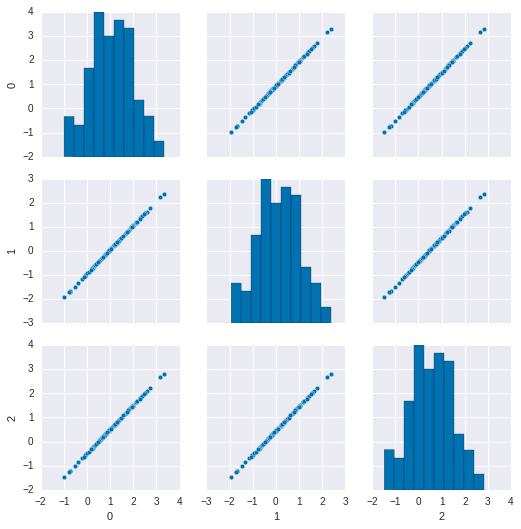

In [23]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.16

In [24]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### Code 5.17 to 5.20

In [25]:
dcc = d.dropna().copy()

In [26]:
with pm.Model() as model_5_5:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['neocortex.perc'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_5 = pm.sample(1000)

100%|██████████| 1000/1000 [00:19<00:00, 52.17it/s]


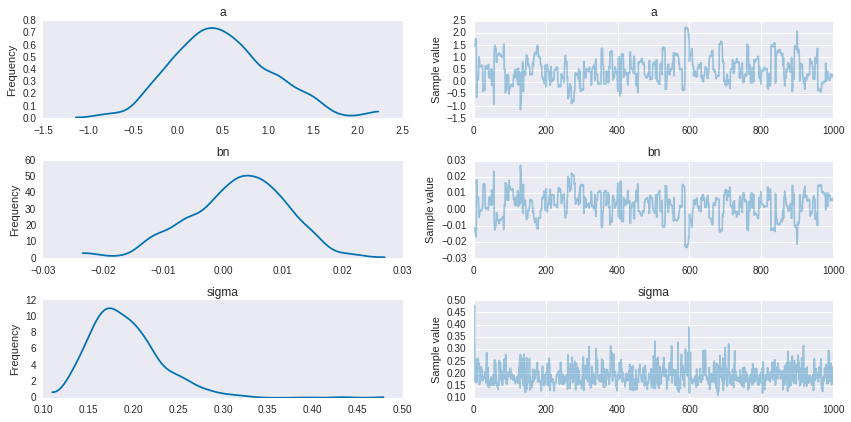

In [27]:
varnames = ['a', 'bn', 'sigma']
pm.traceplot(trace_5_5, varnames);

#### Code 5.21

In [28]:
pm.df_summary(trace_5_5, varnames).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.492,0.548,0.041,-0.400,1.570
bn,0.002,0.008,0.001,-0.013,0.015
sigma,0.192,0.041,0.002,0.126,0.267


#### Code 5.22

In [29]:
trace_5_5['bn'].mean() * (76 - 55)

0.051642057417481922

#### Code 5.23

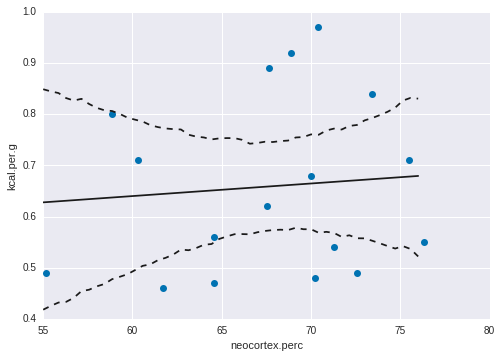

In [30]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_5['a'] + trace_5_5['bn'] * seq[:,None]
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(d['neocortex.perc'], d['kcal.per.g'], 'bo')

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.24

In [31]:
dcc['log_mass'] = np.log(dcc['mass'])

#### Code 5.25

In [32]:
with pm.Model() as model_5_6:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_6 = pm.sample(1000)

100%|██████████| 1000/1000 [00:04<00:00, 244.33it/s]


In [33]:
pm.df_summary(trace_5_6, varnames).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.70,0.05,0.0,0.60,0.82
bn,-0.03,0.02,0.0,-0.08,0.02
sigma,0.18,0.04,0.0,0.11,0.24


#### Code 5.26

In [34]:
with pm.Model() as model_5_7:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn[0] * dcc['neocortex.perc'] + bn[1] * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_7 = pm.sample(1000)

100%|██████████| 1000/1000 [00:27<00:00, 35.78it/s]


In [35]:
pm.df_summary(trace_5_7, varnames).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,-1.10,0.83,0.07,-2.44,0.48
bn__0,0.03,0.01,0.00,0.00,0.05
bn__1,-0.10,0.04,0.00,-0.16,-0.03
sigma,0.15,0.04,0.00,0.09,0.21


#### Code 5.27

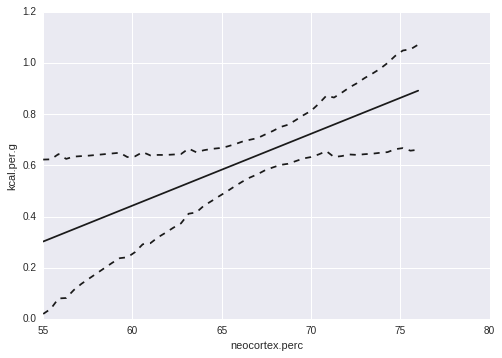

In [36]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_7['a'] + trace_5_7['bn'][:,0] * seq[:,None] + trace_5_7['bn'][:,1] * dcc['log_mass'].mean()
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.28

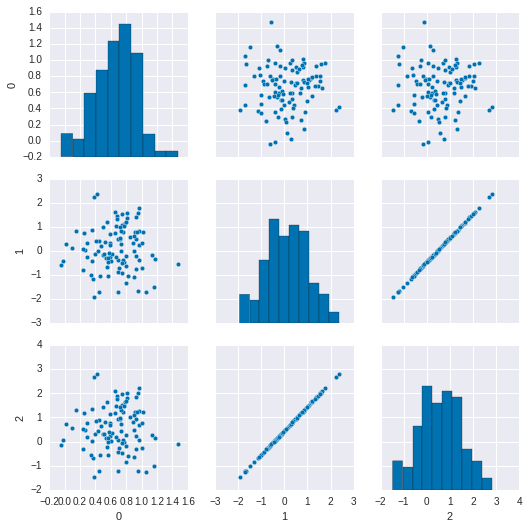

In [37]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(rho*x_pos, (1-rho**2)**0.5)
y = stats.norm.rvs(x_pos - x_neg)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.29

In [38]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5) 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
d = pd.DataFrame([height,leg_left,leg_right])
d

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,9.286656,11.054544,7.840297,8.348026,9.729882,11.696472,9.969640,11.285911,9.123085,6.773019,...,8.912922,11.198070,9.745817,11.981213,11.959102,11.013180,10.970895,10.476561,8.385555,12.332349
1,4.325575,5.508849,5.718277,7.022404,6.364148,7.789605,5.750156,7.530454,4.094720,3.672776,...,6.284360,8.805927,6.505379,7.912206,5.576298,6.459129,7.783859,4.917725,3.895358,5.688407
2,4.313361,5.514971,5.749980,7.034209,6.385403,7.773034,5.776854,7.579777,4.173109,3.600664,...,6.303974,8.767034,6.498752,7.895153,5.601660,6.451594,7.760286,4.893372,3.949806,5.720101


#### Code 5.30

In [39]:
with pm.Model() as m5_8:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    br = pm.Normal('br',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left + br * leg_right)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=d)
    trace_5_8 = pm.sample(1000)

100%|██████████| 1000/1000 [02:36<00:00,  6.39it/s]


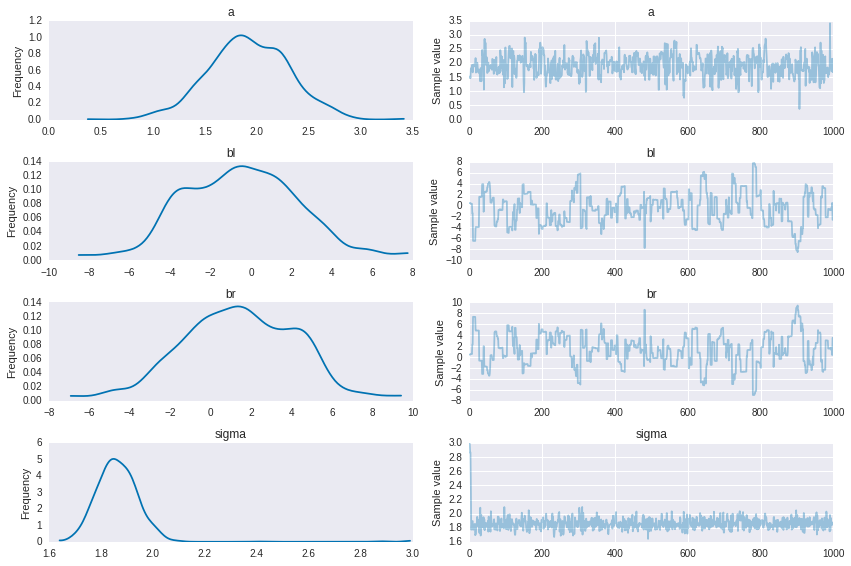

In [40]:
varnames=['a', 'bl', 'br', 'sigma']
pm.traceplot(trace_5_8, varnames);

#### Code 5.31

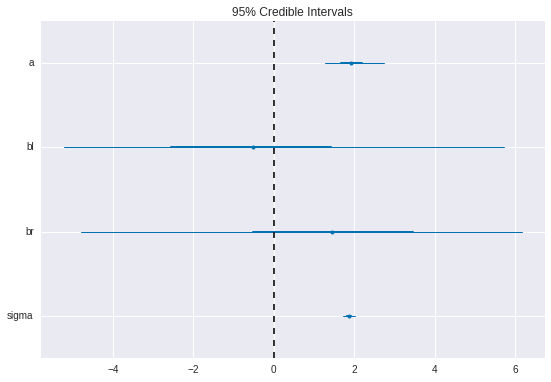

In [41]:
pm.forestplot(trace_5_8, varnames);

#### Code 5.32

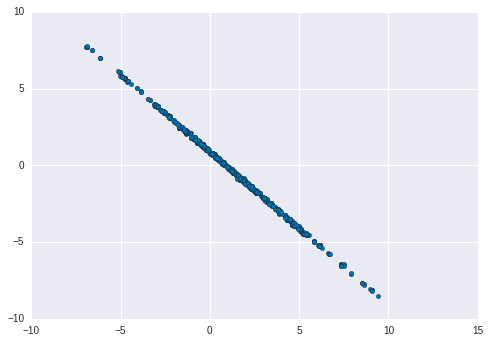

In [42]:
plt.scatter(trace_5_8['br'], trace_5_8['bl']);

#### Code 5.33

/home/agustina/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


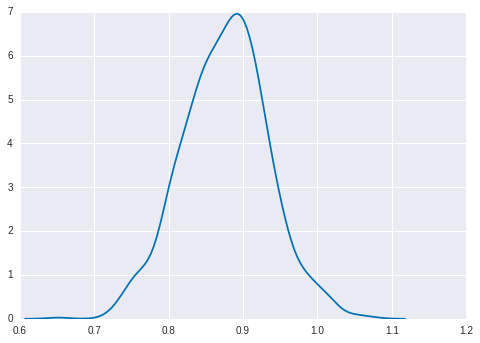

In [43]:
sum_blbr = trace_5_8['br'] + trace_5_8['bl']
sns.kdeplot(sum_blbr);

#### Code 5.34

In [44]:
with pm.Model() as m5_9:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=d)
    trace_5_9 = pm.sample(1000)

100%|██████████| 1000/1000 [00:08<00:00, 112.48it/s]


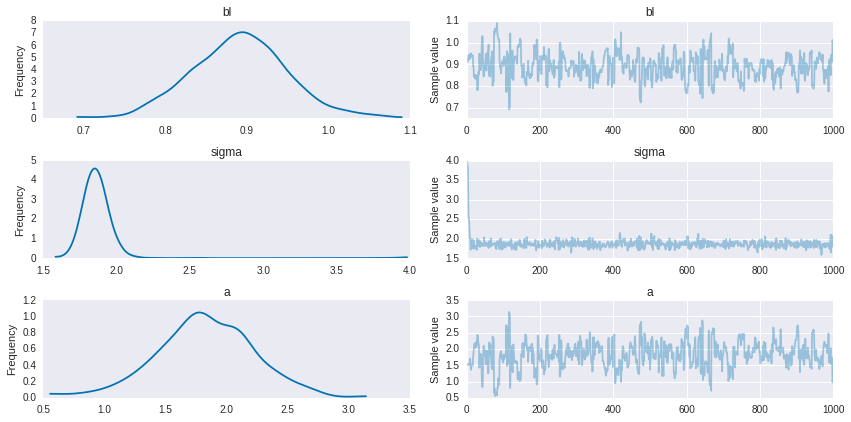

In [45]:
varnames_1 = ['bl', 'sigma', 'a']
pm.traceplot(trace_5_9, varnames_1);

#### Code 5.35

In [46]:
milk = pd.read_csv('Data/milk.csv', sep=';')
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### Code 5.36

In [47]:
with pm.Model() as m5_10:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_10 = pm.sample(1000)

100%|██████████| 1000/1000 [00:05<00:00, 177.93it/s]


In [48]:
varnames = ['a', 'bf', 'sigma']
pm.df_summary(trace_5_10, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.297567,0.039105,0.002479,0.219399,0.377280
bf,0.010137,0.001039,0.000065,0.008043,0.012213
sigma,0.079660,0.011776,0.000502,0.059188,0.103021


In [49]:
with pm.Model() as m5_11:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_11 = pm.sample(1000)

100%|██████████| 1000/1000 [00:12<00:00, 81.32it/s]


In [50]:
varnames = ['a', 'bl', 'sigma']
pm.df_summary(trace_5_11, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,1.170951,0.044604,0.002851,1.081106,1.255243
bl,-0.010672,0.000874,0.000055,-0.012301,-0.008864
sigma,0.077435,0.219480,0.010190,0.049074,0.085994


#### Code 5.37

In [51]:
with pm.Model() as m5_12:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'] + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_12 = pm.sample(1000)

100%|██████████| 1000/1000 [00:28<00:00, 35.57it/s]


In [52]:
varnames = ['a', 'bf', 'bl', 'sigma']
pm.df_summary(trace_5_12, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,1.016422,0.226822,0.018544,0.620920,1.447965
bf,0.001853,0.002781,0.000221,-0.003217,0.007338
bl,-0.008833,0.002768,0.000224,-0.013920,-0.003800
sigma,0.073901,0.134468,0.005210,0.051929,0.092771


#### Code 5.38

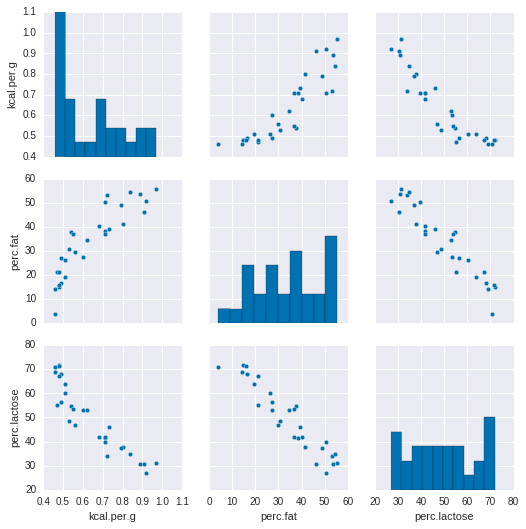

In [53]:
df = milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

#### Code 5.39

In [54]:
milk.corr()['perc.fat']['perc.lactose']

-0.94163734568392821

#### Code 5.40

In [ ]:
def simcoll(r = 0.9):
    milk['x'] = stats.norm.rvs(size=len(milk), loc = r * milk['perc.fat'],
                       scale = np.sqrt((1 - r**2) * milk['perc.fat'].var()))
    X = np.column_stack((milk['perc.fat'], milk['x']))
    m = sm.OLS(milk['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]

    return np.mean(stddev)
    

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation')
plt.ylabel('stddev')

#### Code 5.41

In [56]:
# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(size = N, loc = 10, scale = 2)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment * 0.4), size=N)
h1 = h0 + stats.norm.rvs(size= N, loc= 5- 3*fungus, scale=1)

# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})

#### Code 5.42

In [57]:
with pm.Model() as m5_13:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    bf = pm.Normal('bf',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment + bf * fungus)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed = d['h1'].get_values())
    trace_5_13 = pm.sample(1000) 

100%|██████████| 1000/1000 [00:15<00:00, 66.64it/s]


In [58]:
varnames = ['a', 'bh', 'bt', 'bf', 'sigma']
pm.df_summary(trace_5_13, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,5.582878,0.539705,0.038015,4.642938,6.789064
bh,0.966940,0.050909,0.003579,0.862486,1.061153
bt,-0.188112,0.210050,0.009333,-0.590335,0.229270
bf,-2.919195,0.228901,0.009789,-3.373701,-2.463852
sigma,0.979773,0.195383,0.012183,0.821219,1.100734


#### Code 5.43

In [59]:
with pm.Model() as m5_14:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed =d['h1'])
    trace_5_14 = pm.sample(1000) 

100%|██████████| 1000/1000 [00:13<00:00, 80.13it/s]


In [60]:
varnames = ['a', 'bh', 'bt', 'sigma']
pm.df_summary(trace_5_14, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,4.073841,0.860802,0.060489,2.400999,5.770883
bh,0.965572,0.084415,0.005937,0.801966,1.135753
bt,0.985247,0.306631,0.012260,0.370314,1.524577
sigma,1.597766,0.157427,0.006937,1.387345,1.789728


#### Code 5.44

In [61]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


#### Code 5.45

In [62]:
with pm.Model() as m5_15:
    a = pm.Normal('a',mu = 178, sd=100)
    bm = pm.Normal('bm',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bm * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15 = pm.sample(1000) 

100%|██████████| 1000/1000 [00:03<00:00, 300.23it/s]


In [63]:
varnames = ['a', 'bm', 'sigma']
pm.df_summary(trace_5_15, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,134.775118,1.598777,0.072165,131.384878,137.717124
bm,7.368354,2.252421,0.107497,2.950215,11.825019
sigma,27.417465,0.841659,0.033036,25.713659,29.024824


#### Code 5.46

In [64]:
mu.male = trace_5_15['a'] + trace_5_15['bm']
pm.hpd(mu.male)

array([ 138.66558086,  145.47363812])

#### Code 5.47

In [65]:
with pm.Model() as m5_15b:
    af = pm.Normal('af',mu = 178, sd=100)
    am = pm.Normal('am',mu = 178, sd=100)
    mu = pm.Deterministic('mu',af * (1 - d['male']) + am * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15b = pm.sample(1000) 

100%|██████████| 1000/1000 [00:05<00:00, 174.17it/s]


#### Code 5.48

In [5]:
d = pd.read_csv('Data/milk.csv', sep=';')
d = d.drop_duplicates()

#### Code 5.49

In [6]:
d['clade.NWM'] = np.where( d['clade'] == 'New World Monkey', 1, 0)
d['clade.NWM'].get_values()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

#### Code 5.50

In [7]:
d['clade.OWM'] = np.where( d['clade'] == 'Old World Monkey', 1, 0)
d['clade.S'] = np.where( d['clade'] == 'Strepsirrhine', 1, 0)

#### Code 5.51

In [11]:
with pm.Model() as m5_16:
    a = pm.Normal('a', mu = 0.6, sd=10)
    b_NWM = pm.Normal('b_NWM',mu = 0, sd=1)
    b_OWM = pm.Normal('b_OWM',mu = 0, sd=1)
    b_S = pm.Normal('b_S',mu = 0, sd=1)
    mu = pm.Deterministic('mu', a + 
                          b_NWM * d['clade.NWM'] + 
                          b_OWM * d['clade.OWM'] +
                          b_S * d['clade.S'])

    mu_ape = pm.Deterministic('mu_ape', a + 0)
    mu_NWM = pm.Deterministic('mu_NWM', a + b_NWM)
    mu_OWM = pm.Deterministic('mu_OWM', a + b_OWM)
    mu_S =  pm.Deterministic('mu_S', a + b_S)
    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = mu, sd=sigma, observed = d['kcal.per.g'])
    trace_5_16 = pm.sample(1000)

100%|██████████| 1500/1500 [00:03<00:00, 389.24it/s]


In [12]:
varnames = ['a', 'b_NWM', 'b_OWM', 'b_S', 'sigma']
pm.df_summary(trace_5_16, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
a,0.549372,0.044096,0.001873,0.461217,0.638612
b_NWM,0.163732,0.061552,0.002319,0.047211,0.291624
b_OWM,0.238401,0.070861,0.002670,0.108099,0.383322
b_S,-0.042989,0.075547,0.002884,-0.189172,0.101431
sigma,0.128617,0.020488,0.000962,0.096052,0.173965


#### Code 5.52

In [13]:
varnames = ['mu_ape', 'mu_NWM', 'b_OWM', 'b_S']
pm.df_summary(trace_5_16, varnames)[['mean', 'sd', 'hpd_2.5', 'hpd_97.5']]

,mean,sd,hpd_2.5,hpd_97.5
mu_ape,0.549372,0.044096,0.461217,0.638612
mu_NWM,0.713104,0.042935,0.633753,0.795950
b_OWM,0.238401,0.070861,0.108099,0.383322
b_S,-0.042989,0.075547,-0.189172,0.101431


#### Code 5.53

In [73]:
diff_NMW_OWM = mu_NWM - mu_OWM
np.percentile(diff_NMW_OWM, 2.5), np.percentile(diff_NMW_OWM, 50), np.percentile(diff_NMW_OWM, 97.5)

(-0.22264639462132879, -0.072324314824682656, 0.07009190730894839)

#### Code 5.54

In [88]:
z = pd.Categorical(d['clade'])
d['clade_id'] = z.codes

#### Code 5.55

In [75]:
with pm.Model() as m5_16_alt:
    a = pm.Normal('a',mu = 0.6, sd=10)
    mu = pm.Deterministic('mu', a)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = mu, sd=sigma, observed = d['kcal.per.g'])
    trace_5_16_alt = pm.sample(1000) 

100%|██████████| 1000/1000 [00:02<00:00, 362.57it/s]


In [93]:
varnames = ['mu', 'sigma']
pm.df_summary(trace_5_16_alt, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,0.642266,0.032744,0.001469,0.583994,0.710378
sigma,0.187940,0.295894,0.020516,0.123929,0.211362


The following cells (5.56-5.61) correspond to example code for the use of R's function: lm. Therefore they have no output.

#### Code 5.62

In [15]:
data  = pd.read_csv('Data/cars.csv', sep=',') 
pm.GLM.from_formula('dist ~ speed', data=data)        

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))